In [18]:
import boto3

client=boto3.client('sts')
account=client.get_caller_identity()['Account']

my_session=boto3.session.Session()
region=my_session.region_name

algorithm_name="pytorch-tft-container-test"
ecr_image='{}.dkr.ecr.{}.amazonaws.com/{}:latest'.format(account, region, algorithm_name)

ecr_image

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


'551329315830.dkr.ecr.us-east-1.amazonaws.com/pytorch-tft-container-test:latest'

In [19]:
! aws ecr get-login-password --region us-east-1 | docker login --username AWS --password-stdin 763104351884.dkr.ecr.us-east-1.amazonaws.com

WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded


In [20]:
import sagemaker
import uuid

sagemaker_session = sagemaker.Session()
print('SageMaker version: ' + sagemaker.__version__)

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/DEMO-pytorch-cnn-cifar10'

role = sagemaker.get_execution_role()
checkpoint_suffix = str(uuid.uuid4())[:8]
checkpoint_s3_path = 's3://{}/checkpoints/checkpoint-{}'.format(bucket, checkpoint_suffix)

print('Checkpointing Path: {}'.format(checkpoint_s3_path))

SageMaker version: 2.103.0
Checkpointing Path: s3://sagemaker-us-east-1-551329315830/checkpoints/checkpoint-9724d97d


In [21]:
from utils_timeseries import download_process_and_return_raw_data, save_local_and_upload_s3, metadata_json_upload_s3
import sagemaker
import uuid

max_prediction_length = 6
max_encoder_length = 24
special_days = [
        "easter_day",
        "good_friday",
        "new_year",
        "christmas",
        "labor_day",
        "independence_day",
        "revolution_day_memorial",
        "regional_games",
        "fifa_u_17_world_cup",
        "football_gold_cup",
        "beer_capital",
        "music_fest",
    ]

training_metadata = {}
training_metadata['time_idx'] = "time_idx"
training_metadata['target'] = "volume"
training_metadata['group_ids'] = ["agency", "sku"]
training_metadata['min_encoder_length'] = max_encoder_length // 2      # keep encoder length long (as it is in the validation set)
training_metadata['max_encoder_length'] = max_encoder_length
training_metadata['min_prediction_length'] = 1      
training_metadata['max_prediction_length'] = max_prediction_length
training_metadata['static_categoricals'] = ["agency", "sku"]
training_metadata['static_reals'] = ["avg_population_2017", "avg_yearly_household_income_2017"]
training_metadata['time_varying_known_categoricals'] = ["special_days", "month"]
training_metadata['variable_groups'] = {"special_days": special_days}
training_metadata['time_varying_known_reals'] = ["time_idx", "price_regular", "discount_in_percent"]
training_metadata['time_varying_unknown_categoricals'] = []
training_metadata['time_varying_unknown_reals'] = [
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ]
training_metadata['target_normalizer'] = {
                            "normalized_groups": ["agency", "sku"],
                            "normalization_transformation": 'softplus'
                        }
training_metadata['add_relative_time_idx'] = True
training_metadata['add_target_scales'] = True
training_metadata['add_encoder_length'] = True




sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

# obtain & upload training data
training_data = download_process_and_return_raw_data()
inputs = save_local_and_upload_s3(training_data, sagemaker_session, bucket, data_filename="stallion_data")

# upload metadata
training_metadata['training_cutoff'] = int(training_data["time_idx"].max() - max_prediction_length)
metadata_json_upload_s3(training_metadata, sagemaker_session, bucket, metadata_filename="stallion_metadata")

Checkpointing directory timeseries_data exists
saved raw data to timeseries_data/stallion_data.parquet
Checkpointing directory timeseries_data exists
saved metadata to timeseries_data/stallion_metadata.json


's3://sagemaker-us-east-1-551329315830/data/timeseries_data'

In [22]:
use_spot_instances = False
max_run=6000      # in seconds, after this, job will be terminated
max_wait = 10 * max_run if use_spot_instances else None
local_image_name = 'pytorch-tft-container-test'

In [23]:
from sagemaker.pytorch import PyTorch
from sagemaker.estimator import Estimator
from sagemaker.debugger import TensorBoardOutputConfig


hyperparameters = {
        'epochs': 30, 
        'data-filename': "stallion_data.parquet",
        'metadata-filename': "stallion_metadata.json"
    }

tensorboard_output_config = TensorBoardOutputConfig(
    s3_output_path='s3://sagemaker-us-east-1-551329315830/tensorboard',
    container_local_output_path='/lightning_logs'
)

spot_estimator  = PyTorch(entry_point='TFT_docker/TFT.py',
                            dependencies=['TFT_docker/requirements.txt'],
                            role=role,
                            framework_version='1.7.1',
                            py_version='py3',
                            instance_count=1,
#                             instance_type='local',
                            instance_type='ml.p3.2xlarge',
#                             instance_type='ml.p2.xlarge',
                            base_job_name='tft-pytorch-spot-1',
                            hyperparameters=hyperparameters,
                            checkpoint_s3_uri=checkpoint_s3_path,
                            debugger_hook_config=False,
                            input_mode = 'FastFile',
                            use_spot_instances=use_spot_instances,
                            max_run=max_run,
                            max_wait=max_wait,
                            tensorboard_output_config=tensorboard_output_config
                           )

spot_estimator.fit(
                inputs,
                logs = 'All'
            )

2022-08-22 15:15:55 Starting - Starting the training job...ProfilerReport-1661181355: InProgress
...
2022-08-22 15:16:55 Starting - Preparing the instances for training.........
2022-08-22 15:18:19 Downloading - Downloading input data...
2022-08-22 15:18:39 Training - Downloading the training image....................bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-08-22 15:22:02,864 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-08-22 15:22:02,892 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-08-22 15:22:02,899 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-08-22 15:22:03,326 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python3.6 -m pip install -r requirements.txt

2022-08-22 15:22:20 Training - Training image download completed. Traini

  Created wheel for fastparquet: filename=fastparquet-0.8.0-cp36-cp36m-linux_x86_64.whl size=1256907 sha256=77b245b764cd78d044c91d71bada9675c4d5898d8ac1a804c78b042bcd3b7eee
  Stored in directory: /root/.cache/pip/wheels/6a/6a/4f/0fd8e8bcbc4b5b751186e363b5b03975d8643eee2975eed2ca
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-py3-none-any.whl size=3161 sha256=8e643f50d08f7ba580fac9d267c43017f6fe836a76911974762194ce8192a501
  Stored in directory: /root/.cache/pip/wheels/6a/f5/9c/f8331a854f7a8739cf0e74c13854e4dd7b1af11b04fe1dde13
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11106 sha256=eae72b0927186688484090f65b0caf26ea434d04476ba73e5494808891c0ccf1
  Stored in directory: /root/.cache/pip/wheels/95/38/95/e30a7f0b44cb90642de3469f211a3218f93f871789b4f4b46c
Successfully built fastparquet idna-ssl pyperclip
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.0.1
    Uninstalling importlib-metadata-4.0.1:
   

Distributed training - False
Checkpointing directory /opt/ml/checkpoints exists
Device Type: cuda
Load Time Series dataset from S3
creating dataloader
get GPU information
GPU count: 1
create model trainer
create model from dataset
Number of parameters in network: 29.7k
training model
#015Validation sanity check: 0it [00:00, ?it/s]#015Validation sanity check:   0%|          | 0/1 [00:00<?, ?it/s]#015Validation sanity check: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it]#015                                                                      #015#015Training: 0it [00:00, ?it/s]#015Training:   0%|          | 0/31 [00:00<?, ?it/s]#015Epoch 0:   0%|          | 0/31 [00:00<?, ?it/s] #015Epoch 0:   3%|▎         | 1/31 [00:01<00:34,  1.15s/it]#015Epoch 0:   3%|▎         | 1/31 [00:01<00:34,  1.15s/it, loss=124, v_num=0, train_loss_step=124.0]#015Epoch 0:   6%|▋         | 2/31 [00:01<00:22,  1.28it/s, loss=124, v_num=0, train_loss_step=124.0]#015Epoch 0:   6%|▋         | 2/31 [00:01<00:22,  1.2

#015                                                         #033[A#015Epoch 1: 100%|██████████| 31/31 [00:16<00:00,  1.83it/s, loss=70.9, v_num=0, train_loss_step=79.20, val_loss=105.0, train_loss_epoch=73.20]#015Epoch 1:   0%|          | 0/31 [00:00<?, ?it/s, loss=70.9, v_num=0, train_loss_step=79.20, val_loss=105.0, train_loss_epoch=73.20]         #015Epoch 2:   0%|          | 0/31 [00:00<?, ?it/s, loss=70.9, v_num=0, train_loss_step=79.20, val_loss=105.0, train_loss_epoch=73.20]#015Epoch 2:   3%|▎         | 1/31 [00:00<00:26,  1.13it/s, loss=70.9, v_num=0, train_loss_step=79.20, val_loss=105.0, train_loss_epoch=73.20]#015Epoch 2:   3%|▎         | 1/31 [00:00<00:26,  1.13it/s, loss=70.8, v_num=0, train_loss_step=73.90, val_loss=105.0, train_loss_epoch=73.20]#015Epoch 2:   6%|▋         | 2/31 [00:01<00:19,  1.50it/s, loss=70.8, v_num=0, train_loss_step=73.90, val_loss=105.0, train_loss_epoch=73.20]#015Epoch 2:   6%|▋         | 2/31 [00:01<00:19,  1.50it/s, loss=70, v_num=0, train_los

#015                                                         #033[A#015Epoch 2: 100%|██████████| 31/31 [00:16<00:00,  1.87it/s, loss=64.5, v_num=0, train_loss_step=61.10, val_loss=101.0, train_loss_epoch=64.60]#015Epoch 2:   0%|          | 0/31 [00:00<?, ?it/s, loss=64.5, v_num=0, train_loss_step=61.10, val_loss=101.0, train_loss_epoch=64.60]         #015Epoch 3:   0%|          | 0/31 [00:00<?, ?it/s, loss=64.5, v_num=0, train_loss_step=61.10, val_loss=101.0, train_loss_epoch=64.60]#015Epoch 3:   3%|▎         | 1/31 [00:00<00:26,  1.13it/s, loss=64.5, v_num=0, train_loss_step=61.10, val_loss=101.0, train_loss_epoch=64.60]#015Epoch 3:   3%|▎         | 1/31 [00:00<00:26,  1.13it/s, loss=64.1, v_num=0, train_loss_step=65.40, val_loss=101.0, train_loss_epoch=64.60]#015Epoch 3:   6%|▋         | 2/31 [00:01<00:18,  1.53it/s, loss=64.1, v_num=0, train_loss_step=65.40, val_loss=101.0, train_loss_epoch=64.60]#015Epoch 3:   6%|▋         | 2/31 [00:01<00:19,  1.53it/s, loss=63.5, v_num=0, train_l

#015                                                         #033[A#015Epoch 3: 100%|██████████| 31/31 [00:16<00:00,  1.88it/s, loss=61.8, v_num=0, train_loss_step=76.00, val_loss=91.60, train_loss_epoch=61.70]#015Epoch 3:   0%|          | 0/31 [00:00<?, ?it/s, loss=61.8, v_num=0, train_loss_step=76.00, val_loss=91.60, train_loss_epoch=61.70]         #015Epoch 4:   0%|          | 0/31 [00:00<?, ?it/s, loss=61.8, v_num=0, train_loss_step=76.00, val_loss=91.60, train_loss_epoch=61.70]#015Epoch 4:   3%|▎         | 1/31 [00:00<00:27,  1.11it/s, loss=61.8, v_num=0, train_loss_step=76.00, val_loss=91.60, train_loss_epoch=61.70]#015Epoch 4:   3%|▎         | 1/31 [00:00<00:27,  1.11it/s, loss=60.8, v_num=0, train_loss_step=60.00, val_loss=91.60, train_loss_epoch=61.70]#015Epoch 4:   6%|▋         | 2/31 [00:01<00:19,  1.52it/s, loss=60.8, v_num=0, train_loss_step=60.00, val_loss=91.60, train_loss_epoch=61.70]#015Epoch 4:   6%|▋         | 2/31 [00:01<00:19,  1.52it/s, loss=62.1, v_num=0, train_l

#015                                                         #033[A#015Epoch 4: 100%|██████████| 31/31 [00:17<00:00,  1.82it/s, loss=58.9, v_num=0, train_loss_step=46.90, val_loss=81.50, train_loss_epoch=59.50]#015Epoch 4:   0%|          | 0/31 [00:00<?, ?it/s, loss=58.9, v_num=0, train_loss_step=46.90, val_loss=81.50, train_loss_epoch=59.50]         #015Epoch 5:   0%|          | 0/31 [00:00<?, ?it/s, loss=58.9, v_num=0, train_loss_step=46.90, val_loss=81.50, train_loss_epoch=59.50]#015Epoch 5:   3%|▎         | 1/31 [00:00<00:25,  1.18it/s, loss=58.9, v_num=0, train_loss_step=46.90, val_loss=81.50, train_loss_epoch=59.50]#015Epoch 5:   3%|▎         | 1/31 [00:00<00:25,  1.17it/s, loss=58.6, v_num=0, train_loss_step=48.60, val_loss=81.50, train_loss_epoch=59.50]#015Epoch 5:   6%|▋         | 2/31 [00:01<00:18,  1.56it/s, loss=58.6, v_num=0, train_loss_step=48.60, val_loss=81.50, train_loss_epoch=59.50]#015Epoch 5:   6%|▋         | 2/31 [00:01<00:18,  1.56it/s, loss=58.5, v_num=0, train_l

#015                                                         #033[A#015Epoch 5: 100%|██████████| 31/31 [00:16<00:00,  1.94it/s, loss=54.6, v_num=0, train_loss_step=65.60, val_loss=77.80, train_loss_epoch=56.10]#015Epoch 5:   0%|          | 0/31 [00:00<?, ?it/s, loss=54.6, v_num=0, train_loss_step=65.60, val_loss=77.80, train_loss_epoch=56.10]         #015Epoch 6:   0%|          | 0/31 [00:00<?, ?it/s, loss=54.6, v_num=0, train_loss_step=65.60, val_loss=77.80, train_loss_epoch=56.10]#015Epoch 6:   3%|▎         | 1/31 [00:00<00:27,  1.08it/s, loss=54.6, v_num=0, train_loss_step=65.60, val_loss=77.80, train_loss_epoch=56.10]#015Epoch 6:   3%|▎         | 1/31 [00:00<00:27,  1.08it/s, loss=54.8, v_num=0, train_loss_step=49.20, val_loss=77.80, train_loss_epoch=56.10]#015Epoch 6:   6%|▋         | 2/31 [00:01<00:19,  1.46it/s, loss=54.8, v_num=0, train_loss_step=49.20, val_loss=77.80, train_loss_epoch=56.10]#015Epoch 6:   6%|▋         | 2/31 [00:01<00:19,  1.46it/s, loss=56.4, v_num=0, train_l

#015                                                         #033[A#015Epoch 6: 100%|██████████| 31/31 [00:16<00:00,  1.84it/s, loss=56.3, v_num=0, train_loss_step=52.10, val_loss=79.60, train_loss_epoch=55.20]#015Epoch 6:   0%|          | 0/31 [00:00<?, ?it/s, loss=56.3, v_num=0, train_loss_step=52.10, val_loss=79.60, train_loss_epoch=55.20]         #015Epoch 7:   0%|          | 0/31 [00:00<?, ?it/s, loss=56.3, v_num=0, train_loss_step=52.10, val_loss=79.60, train_loss_epoch=55.20]#015Epoch 7:   3%|▎         | 1/31 [00:00<00:28,  1.07it/s, loss=56.3, v_num=0, train_loss_step=52.10, val_loss=79.60, train_loss_epoch=55.20]#015Epoch 7:   3%|▎         | 1/31 [00:00<00:28,  1.07it/s, loss=55.8, v_num=0, train_loss_step=41.10, val_loss=79.60, train_loss_epoch=55.20]#015Epoch 7:   6%|▋         | 2/31 [00:01<00:19,  1.46it/s, loss=55.8, v_num=0, train_loss_step=41.10, val_loss=79.60, train_loss_epoch=55.20]#015Epoch 7:   6%|▋         | 2/31 [00:01<00:19,  1.46it/s, loss=54.9, v_num=0, train_l

#015                                                         #033[A#015Epoch 7: 100%|██████████| 31/31 [00:16<00:00,  1.84it/s, loss=55.7, v_num=0, train_loss_step=43.90, val_loss=78.30, train_loss_epoch=54.20]#015Epoch 7:   0%|          | 0/31 [00:00<?, ?it/s, loss=55.7, v_num=0, train_loss_step=43.90, val_loss=78.30, train_loss_epoch=54.20]         #015Epoch 8:   0%|          | 0/31 [00:00<?, ?it/s, loss=55.7, v_num=0, train_loss_step=43.90, val_loss=78.30, train_loss_epoch=54.20]#015Epoch 8:   3%|▎         | 1/31 [00:00<00:25,  1.19it/s, loss=55.7, v_num=0, train_loss_step=43.90, val_loss=78.30, train_loss_epoch=54.20]#015Epoch 8:   3%|▎         | 1/31 [00:00<00:25,  1.19it/s, loss=55.8, v_num=0, train_loss_step=57.90, val_loss=78.30, train_loss_epoch=54.20]#015Epoch 8:   6%|▋         | 2/31 [00:01<00:21,  1.36it/s, loss=55.8, v_num=0, train_loss_step=57.90, val_loss=78.30, train_loss_epoch=54.20]#015Epoch 8:   6%|▋         | 2/31 [00:01<00:21,  1.36it/s, loss=55.7, v_num=0, train_l

#015                                                         #033[A#015Epoch 8: 100%|██████████| 31/31 [00:16<00:00,  1.91it/s, loss=51.4, v_num=0, train_loss_step=51.60, val_loss=78.50, train_loss_epoch=52.50]#015Epoch 8:   0%|          | 0/31 [00:00<?, ?it/s, loss=51.4, v_num=0, train_loss_step=51.60, val_loss=78.50, train_loss_epoch=52.50]         #015Epoch 9:   0%|          | 0/31 [00:00<?, ?it/s, loss=51.4, v_num=0, train_loss_step=51.60, val_loss=78.50, train_loss_epoch=52.50]#015Epoch 9:   3%|▎         | 1/31 [00:00<00:26,  1.14it/s, loss=51.4, v_num=0, train_loss_step=51.60, val_loss=78.50, train_loss_epoch=52.50]#015Epoch 9:   3%|▎         | 1/31 [00:00<00:26,  1.14it/s, loss=51.3, v_num=0, train_loss_step=52.10, val_loss=78.50, train_loss_epoch=52.50]#015Epoch 9:   6%|▋         | 2/31 [00:01<00:22,  1.31it/s, loss=51.3, v_num=0, train_loss_step=52.10, val_loss=78.50, train_loss_epoch=52.50]#015Epoch 9:   6%|▋         | 2/31 [00:01<00:22,  1.31it/s, loss=51.5, v_num=0, train_l

#015                                                         #033[A#015Epoch 9: 100%|██████████| 31/31 [00:16<00:00,  1.87it/s, loss=50.3, v_num=0, train_loss_step=52.10, val_loss=79.40, train_loss_epoch=50.90]#015Epoch 9:   0%|          | 0/31 [00:00<?, ?it/s, loss=50.3, v_num=0, train_loss_step=52.10, val_loss=79.40, train_loss_epoch=50.90]         #015Epoch 10:   0%|          | 0/31 [00:00<?, ?it/s, loss=50.3, v_num=0, train_loss_step=52.10, val_loss=79.40, train_loss_epoch=50.90]#015Epoch 10:   3%|▎         | 1/31 [00:00<00:26,  1.14it/s, loss=50.3, v_num=0, train_loss_step=52.10, val_loss=79.40, train_loss_epoch=50.90]#015Epoch 10:   3%|▎         | 1/31 [00:00<00:26,  1.14it/s, loss=50.8, v_num=0, train_loss_step=56.60, val_loss=79.40, train_loss_epoch=50.90]#015Epoch 10:   6%|▋         | 2/31 [00:01<00:18,  1.54it/s, loss=50.8, v_num=0, train_loss_step=56.60, val_loss=79.40, train_loss_epoch=50.90]#015Epoch 10:   6%|▋         | 2/31 [00:01<00:18,  1.54it/s, loss=50.5, v_num=0, tr

#015                                                         #033[A#015Epoch 10: 100%|██████████| 31/31 [00:16<00:00,  1.85it/s, loss=48.6, v_num=0, train_loss_step=47.50, val_loss=78.20, train_loss_epoch=49.50]#015Epoch 10:   0%|          | 0/31 [00:00<?, ?it/s, loss=48.6, v_num=0, train_loss_step=47.50, val_loss=78.20, train_loss_epoch=49.50]         #015Epoch 11:   0%|          | 0/31 [00:00<?, ?it/s, loss=48.6, v_num=0, train_loss_step=47.50, val_loss=78.20, train_loss_epoch=49.50]#015Epoch 11:   3%|▎         | 1/31 [00:00<00:25,  1.18it/s, loss=48.6, v_num=0, train_loss_step=47.50, val_loss=78.20, train_loss_epoch=49.50]#015Epoch 11:   3%|▎         | 1/31 [00:00<00:25,  1.18it/s, loss=48.3, v_num=0, train_loss_step=47.40, val_loss=78.20, train_loss_epoch=49.50]#015Epoch 11:   6%|▋         | 2/31 [00:01<00:18,  1.59it/s, loss=48.3, v_num=0, train_loss_step=47.40, val_loss=78.20, train_loss_epoch=49.50]#015Epoch 11:   6%|▋         | 2/31 [00:01<00:18,  1.59it/s, loss=48.8, v_num=0, 

#015                                                         #033[A#015Epoch 11: 100%|██████████| 31/31 [00:16<00:00,  1.90it/s, loss=51.1, v_num=0, train_loss_step=40.60, val_loss=75.60, train_loss_epoch=49.30]#015Epoch 11:   0%|          | 0/31 [00:00<?, ?it/s, loss=51.1, v_num=0, train_loss_step=40.60, val_loss=75.60, train_loss_epoch=49.30]         #015Epoch 12:   0%|          | 0/31 [00:00<?, ?it/s, loss=51.1, v_num=0, train_loss_step=40.60, val_loss=75.60, train_loss_epoch=49.30]#015Epoch 12:   3%|▎         | 1/31 [00:00<00:26,  1.13it/s, loss=51.1, v_num=0, train_loss_step=40.60, val_loss=75.60, train_loss_epoch=49.30]#015Epoch 12:   3%|▎         | 1/31 [00:00<00:26,  1.12it/s, loss=50.7, v_num=0, train_loss_step=57.00, val_loss=75.60, train_loss_epoch=49.30]#015Epoch 12:   6%|▋         | 2/31 [00:01<00:19,  1.51it/s, loss=50.7, v_num=0, train_loss_step=57.00, val_loss=75.60, train_loss_epoch=49.30]#015Epoch 12:   6%|▋         | 2/31 [00:01<00:19,  1.51it/s, loss=51.4, v_num=0, 

#015                                                         #033[A#015Epoch 12: 100%|██████████| 31/31 [00:16<00:00,  1.85it/s, loss=47.9, v_num=0, train_loss_step=55.10, val_loss=77.60, train_loss_epoch=49.80]#015Epoch 12:   0%|          | 0/31 [00:00<?, ?it/s, loss=47.9, v_num=0, train_loss_step=55.10, val_loss=77.60, train_loss_epoch=49.80]         #015Epoch 13:   0%|          | 0/31 [00:00<?, ?it/s, loss=47.9, v_num=0, train_loss_step=55.10, val_loss=77.60, train_loss_epoch=49.80]#015Epoch 13:   3%|▎         | 1/31 [00:00<00:26,  1.12it/s, loss=47.9, v_num=0, train_loss_step=55.10, val_loss=77.60, train_loss_epoch=49.80]#015Epoch 13:   3%|▎         | 1/31 [00:00<00:26,  1.12it/s, loss=47.9, v_num=0, train_loss_step=54.80, val_loss=77.60, train_loss_epoch=49.80]#015Epoch 13:   6%|▋         | 2/31 [00:01<00:19,  1.49it/s, loss=47.9, v_num=0, train_loss_step=54.80, val_loss=77.60, train_loss_epoch=49.80]#015Epoch 13:   6%|▋         | 2/31 [00:01<00:19,  1.49it/s, loss=47.4, v_num=0, 

#015                                                         #033[A#015Epoch 13: 100%|██████████| 31/31 [00:16<00:00,  1.88it/s, loss=49.9, v_num=0, train_loss_step=59.00, val_loss=75.90, train_loss_epoch=49.40]#015Epoch 13:   0%|          | 0/31 [00:00<?, ?it/s, loss=49.9, v_num=0, train_loss_step=59.00, val_loss=75.90, train_loss_epoch=49.40]         #015Epoch 14:   0%|          | 0/31 [00:00<?, ?it/s, loss=49.9, v_num=0, train_loss_step=59.00, val_loss=75.90, train_loss_epoch=49.40]#015Epoch 14:   3%|▎         | 1/31 [00:00<00:29,  1.02it/s, loss=49.9, v_num=0, train_loss_step=59.00, val_loss=75.90, train_loss_epoch=49.40]#015Epoch 14:   3%|▎         | 1/31 [00:00<00:29,  1.02it/s, loss=51.4, v_num=0, train_loss_step=71.80, val_loss=75.90, train_loss_epoch=49.40]#015Epoch 14:   6%|▋         | 2/31 [00:01<00:20,  1.43it/s, loss=51.4, v_num=0, train_loss_step=71.80, val_loss=75.90, train_loss_epoch=49.40]#015Epoch 14:   6%|▋         | 2/31 [00:01<00:20,  1.43it/s, loss=51.1, v_num=0, 

#015                                                         #033[A#015Epoch 14: 100%|██████████| 31/31 [00:16<00:00,  1.87it/s, loss=47, v_num=0, train_loss_step=48.00, val_loss=77.60, train_loss_epoch=47.30]#015Epoch 14:   0%|          | 0/31 [00:00<?, ?it/s, loss=47, v_num=0, train_loss_step=48.00, val_loss=77.60, train_loss_epoch=47.30]         #015Epoch 15:   0%|          | 0/31 [00:00<?, ?it/s, loss=47, v_num=0, train_loss_step=48.00, val_loss=77.60, train_loss_epoch=47.30]#015Epoch 15:   3%|▎         | 1/31 [00:00<00:26,  1.11it/s, loss=47, v_num=0, train_loss_step=48.00, val_loss=77.60, train_loss_epoch=47.30]#015Epoch 15:   3%|▎         | 1/31 [00:00<00:26,  1.11it/s, loss=46.5, v_num=0, train_loss_step=38.20, val_loss=77.60, train_loss_epoch=47.30]#015Epoch 15:   6%|▋         | 2/31 [00:01<00:19,  1.51it/s, loss=46.5, v_num=0, train_loss_step=38.20, val_loss=77.60, train_loss_epoch=47.30]#015Epoch 15:   6%|▋         | 2/31 [00:01<00:19,  1.50it/s, loss=45.8, v_num=0, train_lo

#015                                                         #033[A#015Epoch 15: 100%|██████████| 31/31 [00:16<00:00,  1.85it/s, loss=46.3, v_num=0, train_loss_step=44.00, val_loss=78.70, train_loss_epoch=46.80]#015Epoch 15:   0%|          | 0/31 [00:00<?, ?it/s, loss=46.3, v_num=0, train_loss_step=44.00, val_loss=78.70, train_loss_epoch=46.80]         #015Epoch 16:   0%|          | 0/31 [00:00<?, ?it/s, loss=46.3, v_num=0, train_loss_step=44.00, val_loss=78.70, train_loss_epoch=46.80]#015Epoch 16:   3%|▎         | 1/31 [00:00<00:26,  1.14it/s, loss=46.3, v_num=0, train_loss_step=44.00, val_loss=78.70, train_loss_epoch=46.80]#015Epoch 16:   3%|▎         | 1/31 [00:00<00:26,  1.14it/s, loss=46.6, v_num=0, train_loss_step=50.10, val_loss=78.70, train_loss_epoch=46.80]#015Epoch 16:   6%|▋         | 2/31 [00:01<00:19,  1.53it/s, loss=46.6, v_num=0, train_loss_step=50.10, val_loss=78.70, train_loss_epoch=46.80]#015Epoch 16:   6%|▋         | 2/31 [00:01<00:19,  1.52it/s, loss=46, v_num=0, tr

#015                                                         #033[A#015Epoch 16: 100%|██████████| 31/31 [00:17<00:00,  1.82it/s, loss=45.7, v_num=0, train_loss_step=39.10, val_loss=79.10, train_loss_epoch=46.10]#015Epoch 16:   0%|          | 0/31 [00:00<?, ?it/s, loss=45.7, v_num=0, train_loss_step=39.10, val_loss=79.10, train_loss_epoch=46.10]         #015Epoch 17:   0%|          | 0/31 [00:00<?, ?it/s, loss=45.7, v_num=0, train_loss_step=39.10, val_loss=79.10, train_loss_epoch=46.10]#015Epoch 17:   3%|▎         | 1/31 [00:00<00:25,  1.16it/s, loss=45.7, v_num=0, train_loss_step=39.10, val_loss=79.10, train_loss_epoch=46.10]#015Epoch 17:   3%|▎         | 1/31 [00:00<00:25,  1.16it/s, loss=46.5, v_num=0, train_loss_step=53.60, val_loss=79.10, train_loss_epoch=46.10]#015Epoch 17:   6%|▋         | 2/31 [00:01<00:18,  1.55it/s, loss=46.5, v_num=0, train_loss_step=53.60, val_loss=79.10, train_loss_epoch=46.10]#015Epoch 17:   6%|▋         | 2/31 [00:01<00:18,  1.55it/s, loss=46.8, v_num=0, 

#015                                                         #033[A#015Epoch 17: 100%|██████████| 31/31 [00:16<00:00,  1.88it/s, loss=45.5, v_num=0, train_loss_step=38.80, val_loss=78.00, train_loss_epoch=46.70]#015Epoch 17:   0%|          | 0/31 [00:00<?, ?it/s, loss=45.5, v_num=0, train_loss_step=38.80, val_loss=78.00, train_loss_epoch=46.70]         #015Epoch 18:   0%|          | 0/31 [00:00<?, ?it/s, loss=45.5, v_num=0, train_loss_step=38.80, val_loss=78.00, train_loss_epoch=46.70]#015Epoch 18:   3%|▎         | 1/31 [00:00<00:26,  1.12it/s, loss=45.5, v_num=0, train_loss_step=38.80, val_loss=78.00, train_loss_epoch=46.70]#015Epoch 18:   3%|▎         | 1/31 [00:00<00:26,  1.12it/s, loss=45.4, v_num=0, train_loss_step=39.60, val_loss=78.00, train_loss_epoch=46.70]#015Epoch 18:   6%|▋         | 2/31 [00:01<00:18,  1.54it/s, loss=45.4, v_num=0, train_loss_step=39.60, val_loss=78.00, train_loss_epoch=46.70]#015Epoch 18:   6%|▋         | 2/31 [00:01<00:18,  1.54it/s, loss=45.9, v_num=0, 

#015                                                         #033[A#015Epoch 18: 100%|██████████| 31/31 [00:16<00:00,  1.92it/s, loss=45.6, v_num=0, train_loss_step=35.70, val_loss=75.80, train_loss_epoch=47.30]#015Epoch 18:   0%|          | 0/31 [00:00<?, ?it/s, loss=45.6, v_num=0, train_loss_step=35.70, val_loss=75.80, train_loss_epoch=47.30]         #015Epoch 19:   0%|          | 0/31 [00:00<?, ?it/s, loss=45.6, v_num=0, train_loss_step=35.70, val_loss=75.80, train_loss_epoch=47.30]#015Epoch 19:   3%|▎         | 1/31 [00:00<00:27,  1.11it/s, loss=45.6, v_num=0, train_loss_step=35.70, val_loss=75.80, train_loss_epoch=47.30]#015Epoch 19:   3%|▎         | 1/31 [00:00<00:27,  1.11it/s, loss=45.8, v_num=0, train_loss_step=48.70, val_loss=75.80, train_loss_epoch=47.30]#015Epoch 19:   6%|▋         | 2/31 [00:01<00:19,  1.51it/s, loss=45.8, v_num=0, train_loss_step=48.70, val_loss=75.80, train_loss_epoch=47.30]#015Epoch 19:   6%|▋         | 2/31 [00:01<00:19,  1.51it/s, loss=45.8, v_num=0, 

#015                                                         #033[A#015Epoch 19: 100%|██████████| 31/31 [00:16<00:00,  1.87it/s, loss=46.5, v_num=0, train_loss_step=49.90, val_loss=75.70, train_loss_epoch=48.20]#015Epoch 19:   0%|          | 0/31 [00:00<?, ?it/s, loss=46.5, v_num=0, train_loss_step=49.90, val_loss=75.70, train_loss_epoch=48.20]         #015Epoch 20:   0%|          | 0/31 [00:00<?, ?it/s, loss=46.5, v_num=0, train_loss_step=49.90, val_loss=75.70, train_loss_epoch=48.20]#015Epoch 20:   3%|▎         | 1/31 [00:00<00:25,  1.17it/s, loss=46.5, v_num=0, train_loss_step=49.90, val_loss=75.70, train_loss_epoch=48.20]#015Epoch 20:   3%|▎         | 1/31 [00:00<00:25,  1.17it/s, loss=46.9, v_num=0, train_loss_step=50.10, val_loss=75.70, train_loss_epoch=48.20]#015Epoch 20:   6%|▋         | 2/31 [00:01<00:18,  1.54it/s, loss=46.9, v_num=0, train_loss_step=50.10, val_loss=75.70, train_loss_epoch=48.20]#015Epoch 20:   6%|▋         | 2/31 [00:01<00:18,  1.54it/s, loss=47.1, v_num=0, 

#015                                                         #033[A#015Epoch 20: 100%|██████████| 31/31 [00:15<00:00,  1.97it/s, loss=46.8, v_num=0, train_loss_step=53.30, val_loss=75.80, train_loss_epoch=48.20]#015Epoch 20:   0%|          | 0/31 [00:00<?, ?it/s, loss=46.8, v_num=0, train_loss_step=53.30, val_loss=75.80, train_loss_epoch=48.20]         #015Epoch 21:   0%|          | 0/31 [00:00<?, ?it/s, loss=46.8, v_num=0, train_loss_step=53.30, val_loss=75.80, train_loss_epoch=48.20]#015Epoch 21:   3%|▎         | 1/31 [00:01<00:33,  1.13s/it, loss=46.8, v_num=0, train_loss_step=53.30, val_loss=75.80, train_loss_epoch=48.20]#015Epoch 21:   3%|▎         | 1/31 [00:01<00:33,  1.13s/it, loss=46.1, v_num=0, train_loss_step=30.00, val_loss=75.80, train_loss_epoch=48.20]#015Epoch 21:   6%|▋         | 2/31 [00:01<00:22,  1.29it/s, loss=46.1, v_num=0, train_loss_step=30.00, val_loss=75.80, train_loss_epoch=48.20]#015Epoch 21:   6%|▋         | 2/31 [00:01<00:22,  1.29it/s, loss=45.7, v_num=0, 


2022-08-22 15:29:32 Uploading - Uploading generated training model
2022-08-22 15:29:32 Completed - Training job completed
Training seconds: 679
Billable seconds: 679


In [32]:
from sagemaker.s3 import S3Downloader
import tarfile
from pytorch_forecasting import TemporalFusionTransformer

def download_data_from_s3(s3_uri, sagemaker_session):
    S3Downloader.download(
                        s3_uri=s3_uri, 
                        local_path = "./trained_model_artifact",
                        sagemaker_session=sagemaker_session
                )
    return "./trained_model_artifact/model.tar.gz"

model_path = download_data_from_s3(spot_estimator.model_data, sagemaker_session)
tar = tarfile.open(model_path, "r:gz")

checkpointed_model = TemporalFusionTransformer.load_from_checkpoint(tar.extractfile(member=tar.getmember(name="model_trainer.ckpt")))
best_tft = checkpointed_model

In [33]:
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
import torch

max_prediction_length = 6
max_encoder_length = 24
training_cutoff = training_data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    training_data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="volume",
    group_ids=["agency", "sku"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["agency", "sku"],
    static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    time_varying_known_categoricals=["special_days", "month"],
    variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ],
    target_normalizer=GroupNormalizer(
        groups=["agency", "sku"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, training_data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [34]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = checkpointed_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(264.0871)

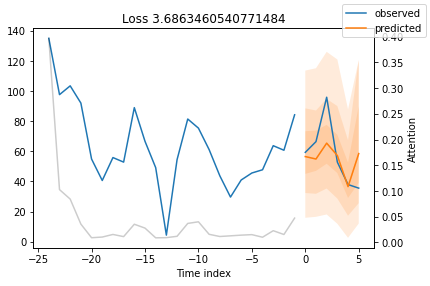

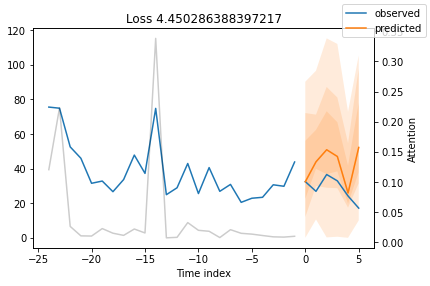

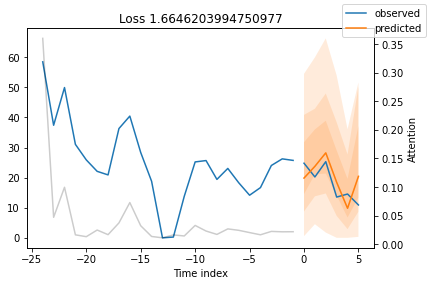

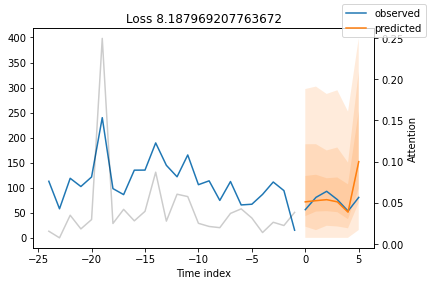

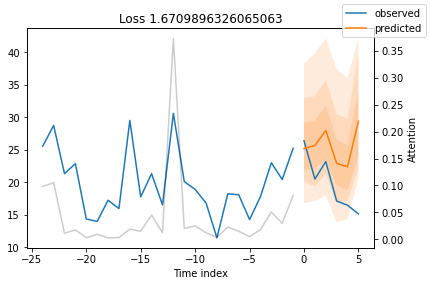

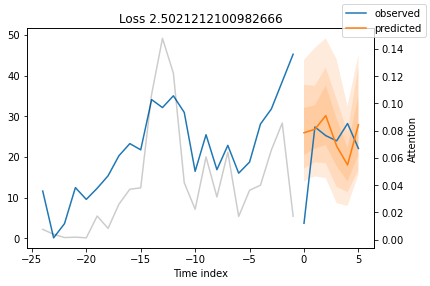

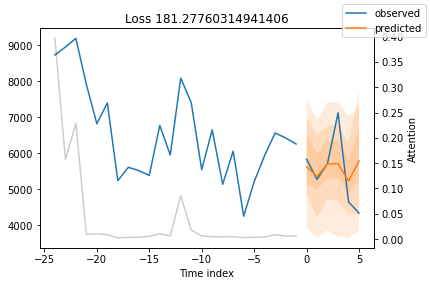

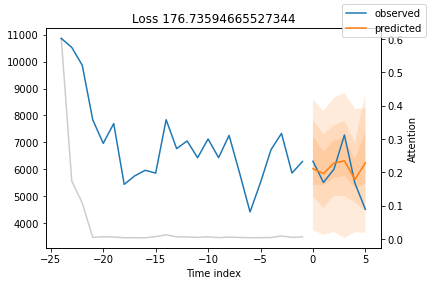

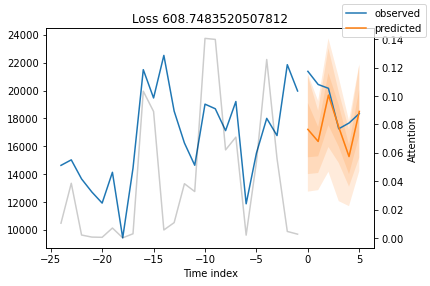

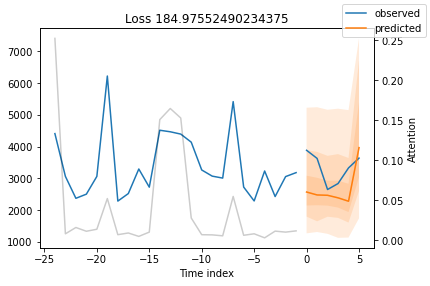

In [35]:

# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);